# AI2 Assignment 2 - Clustering Online Retail

# 1. Initial Exploration of Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Display options.
# pd.set_option('display.max_rows', None) # Display all rows.
# pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Read xlsx file:
# df = pd.read_excel('Online Retail.xlsx')
# df.head()

#Convert to csv file:
# df.to_csv('online_retail.csv', index=False)

In [2]:
# Read and load csv file:
df = pd.read_csv('online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Inspecting descriptive statistics of categorical features:

### (1) Payment Data: InvoiceNo and InvoiceDate

In [5]:
# unique InvoiceNo
df['InvoiceNo'].nunique()

25900

In [6]:
# unique InvoiceDate
df['InvoiceDate'].nunique()

23260

Check if InvoiceNo is 1-1 mapping with InvoiceDate

In [7]:
# check InvoiceNo is 1-1 mapping with InvoiceDate
mapping_invoice = df[['InvoiceNo', 'InvoiceDate']].groupby('InvoiceNo') 

# display mapping_invoice
mapping_invoice.head()

,InvoiceNo,InvoiceDate
0,536365,2010-12-01 08:26:00
1,536365,2010-12-01 08:26:00
2,536365,2010-12-01 08:26:00
3,536365,2010-12-01 08:26:00
4,536365,2010-12-01 08:26:00
...,...,...
541894,581587,2011-12-09 12:50:00
541895,581587,2011-12-09 12:50:00
541896,581587,2011-12-09 12:50:00
541897,581587,2011-12-09 12:50:00


In [8]:
# filter InvoiceNo with multiple InvoiceDate as invoice_check
invoice_check = mapping_invoice.filter(lambda x: x['InvoiceDate'].nunique() > 1)

# create new column 'Unique Date Count' to count the number of unique dates for each invoice in the invoice_check dataframe
invoice_check['Unique Date Count'] = invoice_check.groupby('InvoiceNo')['InvoiceDate'].transform('nunique')

# create new column 'No of Transactions' to count of rows for each InvoiceNo
invoice_check['No of Transactions'] = invoice_check.groupby('InvoiceNo')['InvoiceDate'].transform('count')

invoice_check

,InvoiceNo,InvoiceDate,Unique Date Count,No of Transactions
2421,536591,2010-12-01 16:57:00,2,40
2422,536591,2010-12-01 16:57:00,2,40
2423,536591,2010-12-01 16:57:00,2,40
2424,536591,2010-12-01 16:57:00,2,40
2425,536591,2010-12-01 16:57:00,2,40
...,...,...,...,...
498988,578548,2011-11-24 15:02:00,2,52
498989,578548,2011-11-24 15:02:00,2,52
498990,578548,2011-11-24 15:02:00,2,52
498991,578548,2011-11-24 15:03:00,2,52


In [9]:
# unique invoice numbers in invoice_check
invoice_check['InvoiceNo'].nunique()

43

In [10]:
# unique invoice dates in invoice_check
invoice_check['InvoiceDate'].nunique()

86

In [11]:
# unique unique date count in invoice_check
invoice_check['Unique Date Count'].nunique()

1

- With only 1 Unique Date Count (value ==2) for InvoiceNo that has more than 1 InvoiceDate values, we confirm the scenario that InvoiceNo has only either 1 or 2 Date values.

- We will remove the time portion, and check for 1-1 mapping of InvoiceNo to InvoiceDate again later

Check that every invoice line item is tagged to a unique customer ID:

In [12]:
# Group by InvoiceNo and count unique CustomerIDs per invoice
invoice_customer_check = df.groupby('InvoiceNo')['CustomerID'].nunique()

# Filter invoices that have more than 1 unique CustomerID
inconsistent_invoices = invoice_customer_check[invoice_customer_check > 1]

# Extract offending rows from original DataFrame
inconsistent_rows = df[df['InvoiceNo'].isin(inconsistent_invoices.index)]
inconsistent_rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Check for odd values in InvoiceNo such as 'C' which may signify negative quantities/prices

In [13]:
# check if Invoice number contains any characters other than numbers
df['InvoiceNo'].str.contains('[^0-9]', regex=True).sum()

9291

In [14]:
# check the InvoiceNo that contains characters other than numbers and assign to a dataframe
non_numeric_invoice = df[df['InvoiceNo'].str.contains('[^0-9]', regex=True)]

# display non_numeric_invoice
non_numeric_invoice

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [15]:
# from non_numeric_invoice, extract the rows that have InvoiceNo starting with 'C'
invoice_c = non_numeric_invoice[non_numeric_invoice['InvoiceNo'].str.startswith('C')]

invoice_c

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [16]:
# check maximum Quantity of invoice_c
invoice_c['Quantity'].max()

-1

In [17]:
# from non_numeric_invoice, extract the rows that have InvoiceNo not starting with 'C'
invoice_not_c =non_numeric_invoice[~non_numeric_invoice['InvoiceNo'].str.startswith('C')]

invoice_not_c

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [18]:
# check all rows in df with description == 'Adjust bad debt'
df[df['Description'] == 'Adjust bad debt']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


We will remove all invoices that are alphanumeric and negative quantities and unit prices later.

 - From above, invoice_c will be removed when removing negative quantities.
 - We then remove invoice_not_c later on from the final dataframe.

### (2) Product Data: StockCode and Description

1. Check StockCode column against Description for missing values in description. Then, the plan for Section 2.1 later is

a) If corresponding stockcode to missing description value has a mapped value to an available description value, impute by mode

b) If corresponding stockcode has no mapping to any description value, impute as Unknown

2. Check Description column for useless values

### StockCode column:

In [19]:
# unique StockCode
df['StockCode'].nunique()

4070

In [20]:
# unique Description
df['Description'].nunique()

4223

In [21]:
# check StockCode many-many mapping with Description
mapping_stock = df[['StockCode', 'Description']].groupby('StockCode') 

# sort mapping_stock by 'StockCode' and display mapping_stock
# mapping_stock = mapping_stock.apply(lambda x: x.sort_values('StockCode')).reset_index(drop=True)
mapping_stock.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
540511,23635,SET 10 CARDS CHRISTMAS HOLLY 17259
540512,23644,SET 10 CARDS CHRISTMAS TREE 16955
540861,90055,CRACKED GLAZE EARRINGS BROWN
540874,90141B,IVORY PENDANT TRIPLE SHELL NECKLACE


In [22]:
# display example description for StockCode 20713
df[df['StockCode'] == '20713']['Description'].unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

#### For stockcodes >= 2 description:

In [23]:
# filter Stockcode with multiple Description as multiple_desc_df
multiple_desc_df = mapping_stock.filter(lambda x: x['Description'].nunique() > 1)

# create new column 'Unique Description Count' to count the number of unique Description for each StockCode in the multiple_desc_df dataframe
multiple_desc_df['Unique Description Count'] = multiple_desc_df.groupby('StockCode')['Description'].transform('nunique')

# remove duplicates in multiple_desc_df
multiple_desc_df = multiple_desc_df.drop_duplicates().reset_index(drop=True)

# remove NaN values in multiple_desc_df
multiple_desc_df = multiple_desc_df.dropna().reset_index(drop=True)

# sort multiple_desc_df by 'Unique Description Count' in descending order
multiple_desc_df = multiple_desc_df.sort_values(by='Unique Description Count', ascending=False)

# display multiple_desc_df
multiple_desc_df.head(10)


,StockCode,Description,Unique Description Count
912,20713,wrongly marked. 23343 in box,8
1201,20713,wrongly marked 23343,8
1237,20713,wrongly coded 23343,8
1180,20713,found,8
1128,20713,wrongly coded-23343,8
1232,20713,Marked as 23343,8
66,20713,JUMBO BAG OWLS,8
1193,20713,Found,8
1016,23084,allocate stock for dotcom orders ta,7
1039,23084,website fixed,7


In [24]:
multiple_desc_df.shape

(1484, 3)

In [25]:
# unique stock codes in multiple_desc_df (those with multiple descriptions)
multiple_desc_df['StockCode'].nunique()

650

#### For stockcodes == 1 description:

In [26]:
# filter Stockcode with unique Description as unique_desc_df
unique_desc_df = mapping_stock.filter(lambda x: x['Description'].nunique() == 1)

# create new column 'Unique Description Count' to count the number of unique Description for each StockCode in the unique_desc_df dataframe
unique_desc_df['Unique Description Count'] = unique_desc_df.groupby('StockCode')['Description'].transform('nunique')

# remove duplicates in unique_desc_df:
unique_desc_df = unique_desc_df.drop_duplicates().reset_index(drop=True)

# remove NaN values in unique_desc_df
unique_desc_df = unique_desc_df.dropna().reset_index(drop=True)

unique_desc_df

,StockCode,Description,Unique Description Count
0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,1
1,84029E,RED WOOLLY HOTTIE WHITE HEART.,1
2,22752,SET 7 BABUSHKA NESTING BOXES,1
3,21730,GLASS STAR FROSTED T-LIGHT HOLDER,1
4,22633,HAND WARMER UNION JACK,1
...,...,...,...
3303,85179a,GREEN BITTY LIGHT CHAIN,1
3304,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,1
3305,90214U,"LETTER ""U"" BLING KEY RING",1
3306,47591b,SCOTTIES CHILDRENS APRON,1


In [27]:
# unique stock codes in unique_desc_df
unique_desc_df['StockCode'].nunique()

3308

#### For stockcodes == 0 description:

In [28]:
# filter stockcode with no description as no_desc_df
no_desc_df = mapping_stock.filter(lambda x: x['Description'].isnull().all())

# create new column 'Unique Description Count' to count the number of unique Description for each StockCode in the no_desc_df dataframe
no_desc_df['Unique Description Count'] = no_desc_df.groupby('StockCode')['Description'].transform('nunique')

# remove duplicates in no_desc_df
no_desc_df = no_desc_df.drop_duplicates().reset_index(drop=True)


no_desc_df

,StockCode,Description,Unique Description Count
0,21134,NaN,0
1,85226A,NaN,0
2,85044,NaN,0
3,20950,NaN,0
4,84670,NaN,0
...,...,...,...
107,21610,NaN,0
108,37477B,NaN,0
109,37477C,NaN,0
110,35592T,NaN,0


In [29]:
# unique stock codes in no_desc_df
no_desc_df['StockCode'].nunique()

112

### Checking for useless values for 'Descriptions' in lowercase

In [30]:
# if description has no values that has at least 1 uppercase, extract all rows into a dataframe called useless_desc_df
useless_desc_df = df[df['Description'].notna() & ~df['Description'].str.contains(r'[A-Z]', na=False)]

# display useless_desc_df
useless_desc_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [31]:
# if description values are lowercase, extract all values into a list
lowercase_desc = df[df['Description'].notna() & df['Description'].str.islower()]

# display lowercase_desc
lowercase_desc

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [32]:
# unique useless descriptions
useless_desc_df['Description'].nunique()

131

In [33]:
# unique useless descriptions printed in a list
useless_desc_df['Description'].unique()

array(['amazon', '?', 'check', 'damages', 'faulty', 'amazon sales',
       'reverse 21/5/10 adjustment', 'mouldy, thrown away.', 'found',
       'counted', 'label mix up', 'samples/damages', 'thrown away',
       'incorrectly made-thrown away.', 'showroom',
       'wrongly sold as sets', 'dotcom sold sets', 'wrongly sold sets',
       '? sold as sets?', '?sold as sets?', 'damages/display',
       'damaged stock', 'broken', 'throw away', 'wrong barcode (22467)',
       'wrongly sold (22719) barcode', 'wrong barcode', 'barcode problem',
       '?lost', "thrown away-can't sell.", "thrown away-can't sell",
       'rcvd be air temp fix for dotcom sit', 'damages?',
       're dotcom quick fix.', 'sold in set?', 'cracked', 'sold as 22467',
       'damaged', 'did  a credit  and did not tick ret', 'adjustment',
       'returned', 'wrong code?', 'wrong code', 'adjust', 'crushed',
       'damages/showroom etc', 'samples', 'mailout ', 'mailout',
       'sold as set/6 by dotcom', 'wet/rusty', 'dama

In [34]:
# check descriptions in original df that are not in useless_desc_df as useful_desc_df
useful_desc_df = df[~df['Description'].isin(useless_desc_df['Description'])]

# display useful_desc_df
useful_desc_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [35]:
# unique useful descriptions
useful_desc_df['Description'].nunique()

4092

In [36]:
# unique useful descriptions printed in a dictionary:

useful_desc_dict = useful_desc_df['Description'].value_counts().to_dict()
useful_desc_dict

{'WHITE HANGING HEART T-LIGHT HOLDER': 2369,
 'REGENCY CAKESTAND 3 TIER': 2200,
 'JUMBO BAG RED RETROSPOT': 2159,
 'PARTY BUNTING': 1727,
 'LUNCH BAG RED RETROSPOT': 1638,
 'ASSORTED COLOUR BIRD ORNAMENT': 1501,
 'SET OF 3 CAKE TINS PANTRY DESIGN ': 1473,
 'PACK OF 72 RETROSPOT CAKE CASES': 1385,
 'LUNCH BAG  BLACK SKULL.': 1350,
 'NATURAL SLATE HEART CHALKBOARD ': 1280,
 'POSTAGE': 1252,
 'JUMBO BAG PINK POLKADOT': 1251,
 'HEART OF WICKER SMALL': 1237,
 'JAM MAKING SET WITH JARS': 1229,
 'JUMBO STORAGE BAG SUKI': 1214,
 "PAPER CHAIN KIT 50'S CHRISTMAS ": 1210,
 'JUMBO SHOPPER VINTAGE RED PAISLEY': 1202,
 'LUNCH BAG CARS BLUE': 1197,
 'LUNCH BAG SPACEBOY DESIGN ': 1192,
 'JAM MAKING SET PRINTED': 1182,
 'RECIPE BOX PANTRY YELLOW DESIGN': 1180,
 'SPOTTY BUNTING': 1172,
 'LUNCH BAG SUKI DESIGN ': 1139,
 'ROSES REGENCY TEACUP AND SAUCER ': 1138,
 'LUNCH BAG PINK POLKADOT': 1137,
 'WOODEN PICTURE FRAME WHITE FINISH': 1129,
 'SET OF 4 PANTRY JELLY MOULDS': 1111,
 'ALARM CLOCK BAKELIKE RED '

Plan:
- For missing Description, if StockCode in row has >= 1 description, impute mode
- Else, remove row with missing description.
- Also, we will remove useless_desc_df from the original dataframe df later.

### (3) Customer Data: Customer ID and Country

In [37]:
# check unique country
df['Country'].nunique()

38

In [38]:
#  distribution of customerID per country
df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

Country
United Kingdom          3950
Germany                   95
France                    87
Spain                     31
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     15
Finland                   12
Austria                   11
Norway                    10
Netherlands                9
Australia                  9
Channel Islands            9
Denmark                    9
Cyprus                     8
Sweden                     8
Japan                      8
Poland                     6
USA                        4
Canada                     4
Unspecified                4
Israel                     4
Greece                     4
EIRE                       3
Malta                      2
United Arab Emirates       2
Bahrain                    2
Lithuania                  1
Czech Republic             1
Lebanon                    1
RSA                        1
Saudi Arabia               1
Singapore                  1
Icelan

In [39]:
# check that CustomerID only contains numbers in the float format
df['CustomerID'].apply(lambda x: isinstance(x, (int, np.int64, float, np.float64))).all()

True

Plan: 

1. We need to convert CustomerID into an object
2. Impute missing values for CustomerID with 'Non-Member

## Inspecting descriptive statistics of numerical features

### (4) Operational Data: Quantity and Price

<Axes: ylabel='Quantity'>

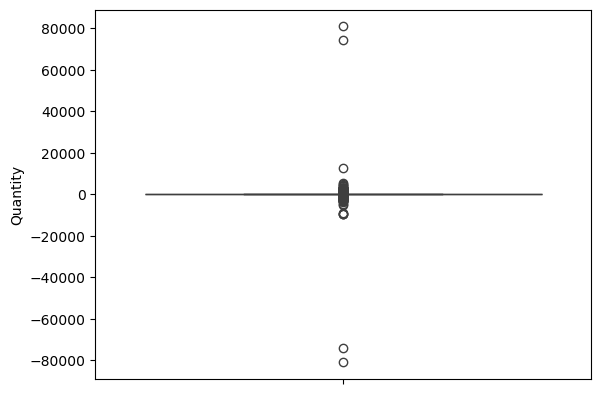

In [40]:
# boxplot of Quantity
sns.boxplot(df['Quantity'])

In [41]:
# display dataframe with Quantity less than 0
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


<Axes: ylabel='UnitPrice'>

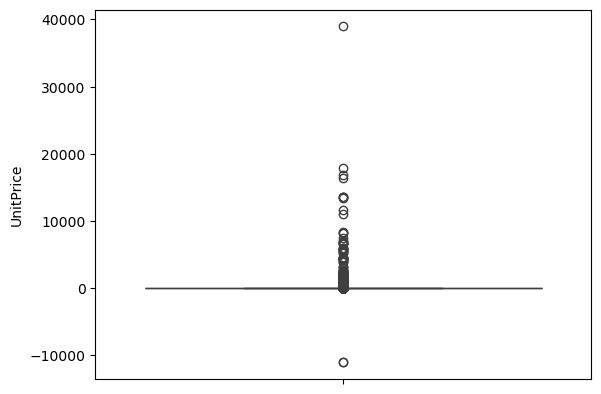

In [42]:
# boxplot of UnitPrice
sns.boxplot(df['UnitPrice'])

In [43]:
# display dataframe with UnitPrice less than 0
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


There are ideally no negative prices and negative quantities. We shall remove:

1. All rows with Quantity < 0
2. invoice_non_c which contains unitprice < 0

## 2.1 Data Cleaning

### (1) Payment Data:

1. InvoiceDate should be Datetime object
2. InvoiceDate to extract only the Date and remove timestring.
3. Then InvoiceDate check if 1-1 match between InvoiceNo and Date.
4. Last, generate new column for InvoiceDate to map to the number of days since 1st day

In [44]:
# Convert InvoiceDate to Datetime:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# display the first 5 rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [45]:
# check the earliest and latest date in the dataframe
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [46]:
# extract only Year Month and Date from InvoiceDate and replace the original InvoiceDate column
df['InvoiceDate'] = df['InvoiceDate'].dt.date

# display the first 5 rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [47]:
# check if 1-1 mapping between InvoiceNo and InvoiceDate
mapping_invoice = df[['InvoiceNo', 'InvoiceDate']].groupby('InvoiceNo') 

# # filter InvoiceNo with multiple InvoiceDate as invoice_check_2 to see if there are any matches
invoice_check_2 = mapping_invoice.filter(lambda x: x['InvoiceDate'].nunique() > 1)
invoice_check_2

,InvoiceNo,InvoiceDate


In [48]:
# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Generate new column 'Day_Number' to extract the number of days from the 1st day of the dataset
df['Day_Number'] = (df['InvoiceDate'] - df['InvoiceDate'].min()).dt.days + 1

# shape of the dataframe
df.shape

(541909, 9)

Remove rows where Description is in invoice_not_c

In [49]:
# remove rows where InvoiceNo is in invoice_not_c from df
df = df[~df['InvoiceNo'].isin(invoice_not_c['InvoiceNo'])]

# shape of the dataframe
df.shape

(541906, 9)

### (2) Product Data: (StockCode and Description)

1. Since Stockcode is the unique identifier of the description:

(a) If description has missing value and corresponding stockcode has >= 1 mapped description, impute by mode

(b) Else, impute as 'No Description'

Impute by mode of description if stockcode > 1 Description

In [50]:
# Create dictionaries for mapping StockCode to description
multiple_desc_dict = multiple_desc_df.groupby('StockCode')['Description'].agg(lambda x: x.mode().iloc[0]).to_dict()
unique_desc_dict = unique_desc_df.set_index('StockCode')['Description'].to_dict()

# Loop through each row and apply logic
for i, row in df.iterrows():
    if pd.isna(row['Description']):
        stock_code = row['StockCode']
        if stock_code in multiple_desc_dict:
            df.at[i, 'Description'] = multiple_desc_dict[stock_code]
        elif stock_code in unique_desc_dict:
            df.at[i, 'Description'] = unique_desc_dict[stock_code]
        else:
            df.at[i, 'Description'] = 'No Description'

# display the first 5 rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day_Number
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,1


In [51]:
# check if there are any missing values in the Description column
df['Description'].isnull().sum()

0

In [52]:
# remove all rows with Description as 'No Description':
df = df[df['Description'] != 'No Description']

# check df.shape
df.shape

(541794, 9)

2. Remove all rows from useless_desc_df:

In [53]:
useless_desc_df.shape

(549, 8)

In [54]:
# if description is in useless_desc_df, remove the row from df
df = df[~df['Description'].isin(useless_desc_df['Description'])]

# check df.shape
df.shape

(541185, 9)

### (3) For Customer Data:

for Customer ID column:
1. Change to object variable
2. Impute missing values as Non-Member - indicating that this Guest is not part of loyalty program.
3. Check every Customer ID has only 1 country value mapped

In [55]:
# inspect CustomerID column
df['CustomerID'].nunique()

4372

In [56]:
# display CustomerID sample values
df['CustomerID'].sample(10)

298816    13588.0
106989    14934.0
368690    18204.0
415312    15782.0
193699        NaN
38078         NaN
96535     16980.0
984       14729.0
383845    16764.0
426322    13137.0
Name: CustomerID, dtype: float64

In [57]:
# Convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)

df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 541185 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541185 non-null  object        
 1   StockCode    541185 non-null  object        
 2   Description  541185 non-null  object        
 3   Quantity     541185 non-null  int64         
 4   InvoiceDate  541185 non-null  datetime64[ns]
 5   UnitPrice    541185 non-null  float64       
 6   CustomerID   541185 non-null  object        
 7   Country      541185 non-null  object        
 8   Day_Number   541185 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 41.3+ MB


In [58]:
# impute missing values in CustomerID column as "Non-Member"
df['CustomerID'] = df['CustomerID'].replace('nan', 'Non-Member')
df['CustomerID'].nunique()

4373

In [59]:
# check proportion of 'Non-Member' in CustomerID
df['CustomerID'].value_counts(normalize=True)

CustomerID
Non-Member    0.248263
17841.0       0.014751
14911.0       0.010908
14096.0       0.009476
12748.0       0.008577
                ...   
13270.0       0.000002
17763.0       0.000002
17291.0       0.000002
15668.0       0.000002
15562.0       0.000002
Name: proportion, Length: 4373, dtype: float64

In [60]:
# remove all .0 from CustomerID
df['CustomerID'] = df['CustomerID'].str.replace('.0', '')

# check the first 5 rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day_Number
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,1


### (4) For Sales Data:

1. Remove all rows with negative values from quantity and price

In [61]:
# check rows with quantity == 0
df[df['Quantity'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day_Number


In [62]:
# remove all rows with Quantity < 0
df = df[df['Quantity'] > 0]

# check df.shape
df.shape

(531094, 9)

Export to parquet for working in a new Notebook:

In [63]:
# describe the dataframe
df.describe()

,Quantity,InvoiceDate,UnitPrice,Day_Number
count,531094.000000,531094,531094.000000,531094.000000
mean,10.614746,2011-07-04 04:19:18.357653760,3.879512,216.180074
min,1.000000,2010-12-01 00:00:00,0.000000,1.000000
25%,1.000000,2011-03-28 00:00:00,1.250000,118.000000
50%,3.000000,2011-07-20 00:00:00,2.080000,232.000000
75%,10.000000,2011-10-19 00:00:00,4.130000,323.000000
max,80995.000000,2011-12-09 00:00:00,13541.330000,374.000000
std,156.611557,NaN,32.516334,115.932421


In [64]:
# export to parquet file
df.to_parquet('df_clean.parquet', index=False)

### Visualization of Data for Non-Members for Section 5 (Excluded in next workbook):

In [68]:
# create dataframe for non-members
non_member_df = df[df['CustomerID'] == 'Non-Member']

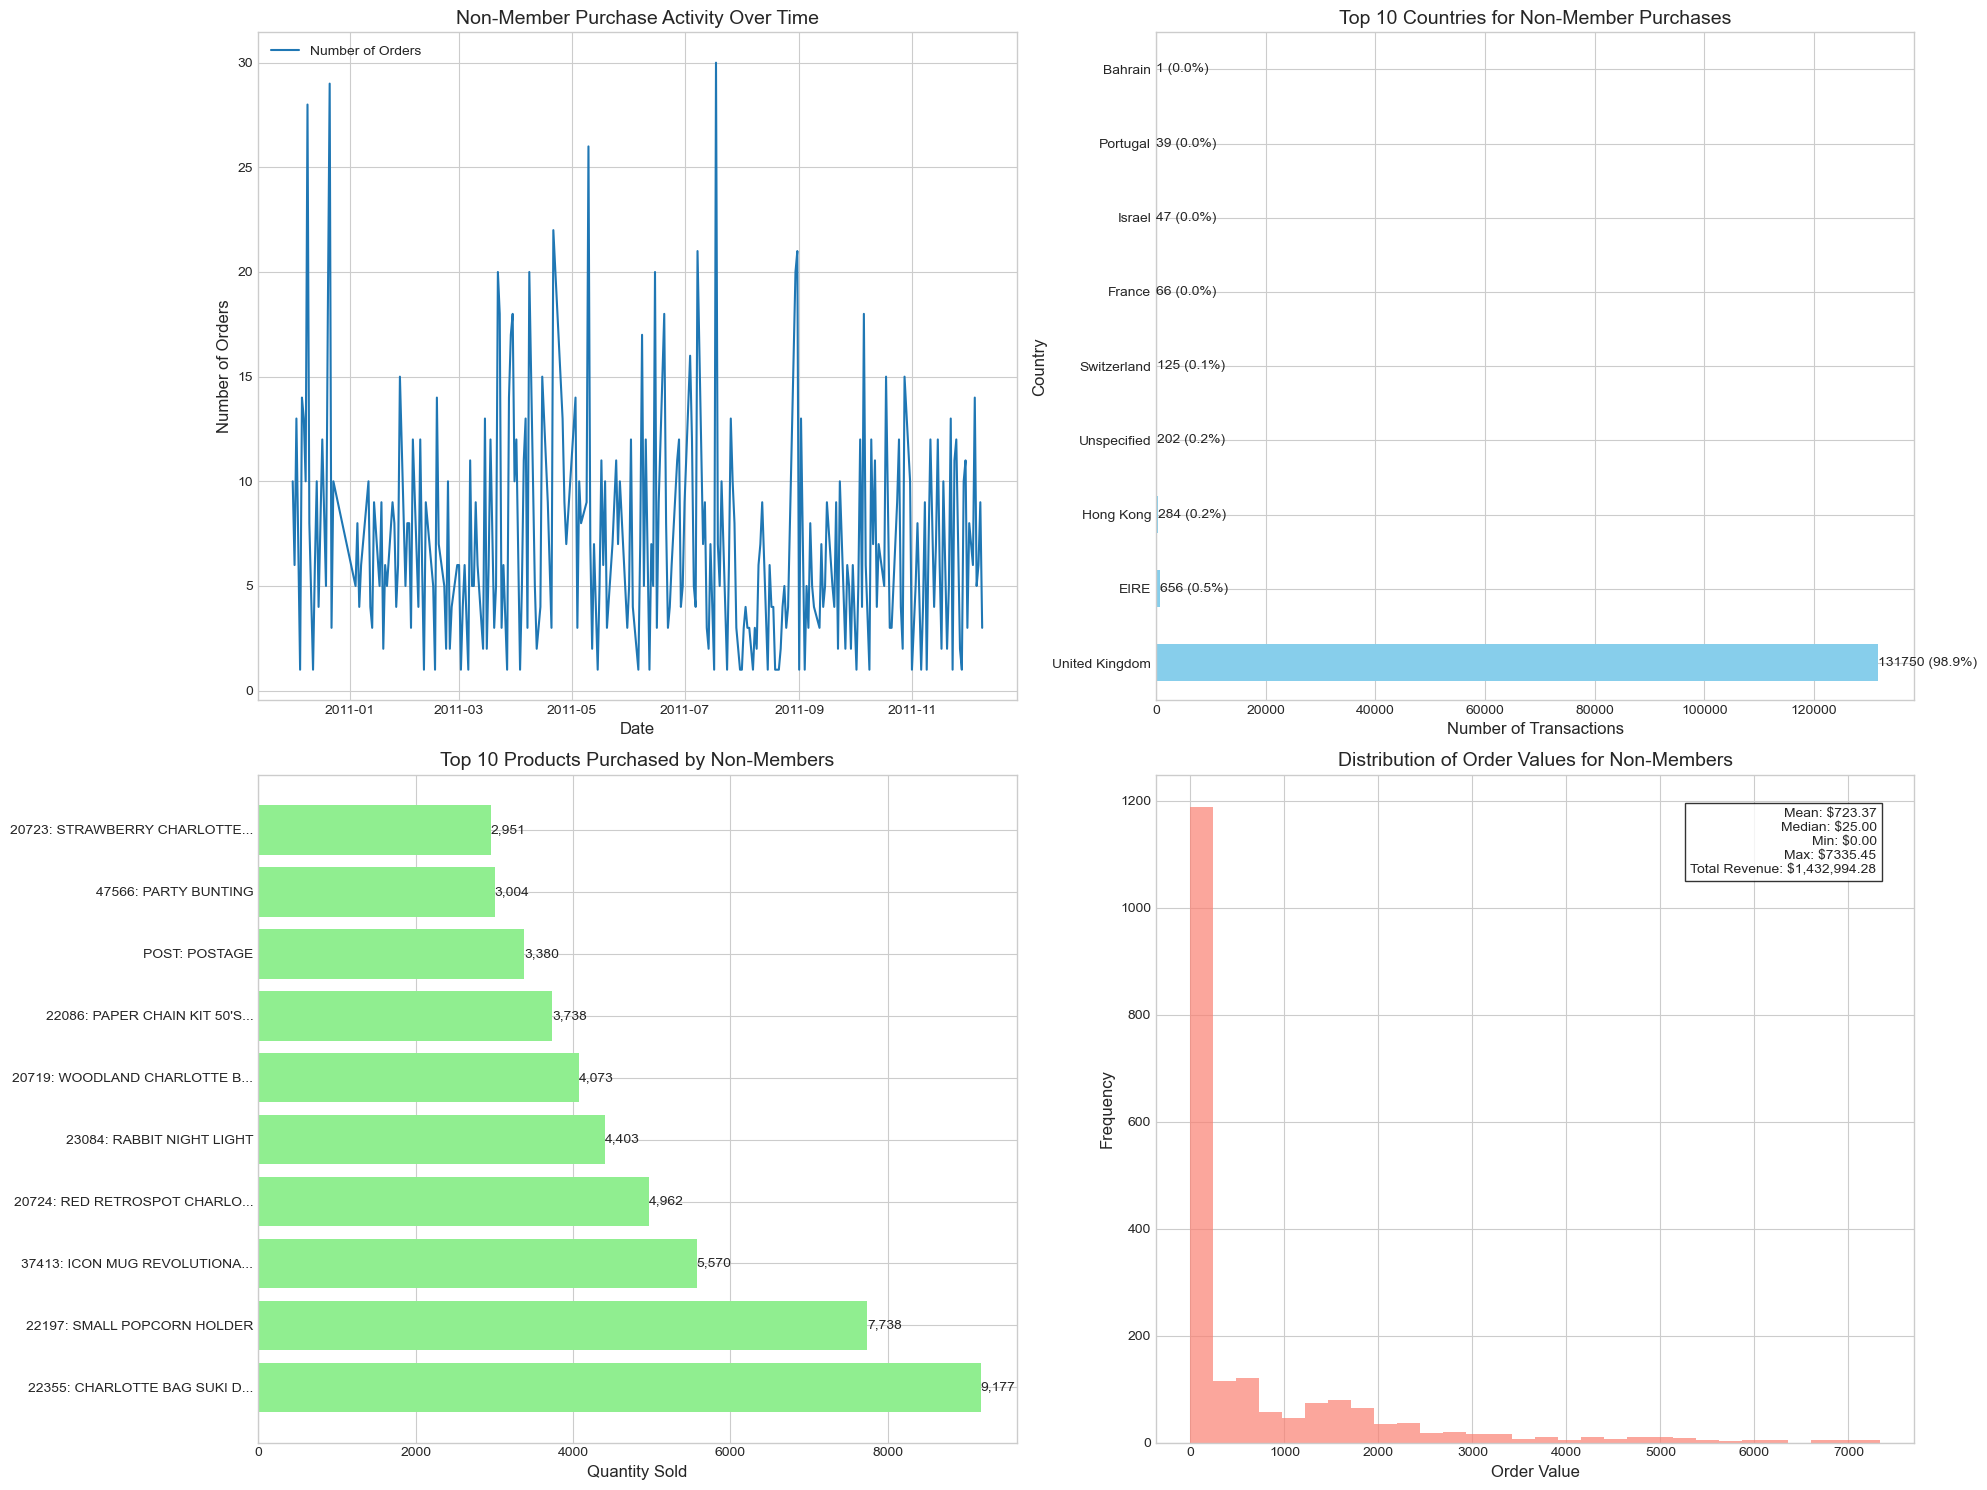


=== Non-Member Customer Statistics ===
Total Non-Member Transactions: 133170
Unique Orders: 2001
Total Items Purchased: 455,732
Countries Served: 9
Unique Products Purchased: 3518
Total Revenue: $1,744,214.58


In [72]:
def visualize_non_member_stats(non_member_df):
    """Visualize aggregate statistics for non-member customers"""
    # Set figure aesthetics
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Purchase Activity Over Time
    ax1 = plt.subplot(2, 2, 1)
    # Aggregate by day
    # Ensure TotalSales column exists
    if 'TotalSales' not in non_member_df.columns:
        non_member_df['TotalSales'] = non_member_df['Quantity'] * non_member_df['UnitPrice']
    
    time_series = non_member_df.groupby(pd.to_datetime(non_member_df['InvoiceDate']).dt.date).agg({
        'InvoiceNo': 'nunique',  # Unique orders
        'Quantity': 'sum',       # Total items
        'TotalSales': 'sum'      # Total sales
    }).fillna(0)
    
    # Plot time series
    time_series['InvoiceNo'].plot(ax=ax1, label='Number of Orders')
    ax1.set_title('Non-Member Purchase Activity Over Time', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Number of Orders', fontsize=12)
    ax1.legend(loc='upper left')
    
    # 2. Top Countries
    ax2 = plt.subplot(2, 2, 2)
    country_counts = non_member_df['Country'].value_counts().head(10)
    country_counts.plot(kind='barh', ax=ax2, color='skyblue')
    ax2.set_title('Top 10 Countries for Non-Member Purchases', fontsize=14)
    ax2.set_xlabel('Number of Transactions', fontsize=12)
    ax2.set_ylabel('Country', fontsize=12)
    
    # Add percentage labels
    total = country_counts.sum()
    for i, v in enumerate(country_counts):
        ax2.text(v + 0.1, i, f"{v} ({v/total:.1%})", va='center')
    
    # 3. Top Products
    ax3 = plt.subplot(2, 2, 3)
    # Get top products by quantity
    top_products = non_member_df.groupby('StockCode').agg({
        'Quantity': 'sum',
        'Description': 'first'  # Get description for the stockcode
    }).sort_values('Quantity', ascending=False).head(10)
    
    # Create product labels (show both code and truncated description)
    product_labels = [f"{code}: {desc[:20]}..." if len(desc) > 20 else f"{code}: {desc}" 
                     for code, desc in zip(top_products.index, top_products['Description'])]
    
    # Plot top products
    bars = ax3.barh(range(len(product_labels)), top_products['Quantity'], color='lightgreen')
    ax3.set_yticks(range(len(product_labels)))
    ax3.set_yticklabels(product_labels)
    ax3.set_title('Top 10 Products Purchased by Non-Members', fontsize=14)
    ax3.set_xlabel('Quantity Sold', fontsize=12)
    
    # Add quantity labels
    for i, bar in enumerate(bars):
        ax3.text(bar.get_width() + 0.1, i, f"{bar.get_width():,.0f}", va='center')
    
    # 4. Purchase Value Distribution
    ax4 = plt.subplot(2, 2, 4)
    
    # Create purchase value column if it doesn't exist
    if 'TotalSales' not in non_member_df.columns:
        purchase_values = non_member_df.groupby('InvoiceNo').apply(
            lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    else:
        purchase_values = non_member_df.groupby('InvoiceNo')['TotalSales'].sum()
    
    # Filter out extreme values for better visualization
    purchase_values = purchase_values[purchase_values.between(
        purchase_values.quantile(0.01), purchase_values.quantile(0.99))]
    
    # Plot histogram
    ax4.hist(purchase_values, bins=30, color='salmon', alpha=0.7)
    ax4.set_title('Distribution of Order Values for Non-Members', fontsize=14)
    ax4.set_xlabel('Order Value', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    
    # Add summary statistics as text
    stats_text = (
        f"Mean: ${purchase_values.mean():.2f}\n"
        f"Median: ${purchase_values.median():.2f}\n"
        f"Min: ${purchase_values.min():.2f}\n"
        f"Max: ${purchase_values.max():.2f}\n"
        f"Total Revenue: ${purchase_values.sum():,.2f}"
    )
    ax4.text(0.95, 0.95, stats_text, transform=ax4.transAxes, 
             ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics summary
    print("\n=== Non-Member Customer Statistics ===")
    print(f"Total Non-Member Transactions: {len(non_member_df)}")
    print(f"Unique Orders: {non_member_df['InvoiceNo'].nunique()}")
    print(f"Total Items Purchased: {non_member_df['Quantity'].sum():,}")
    print(f"Countries Served: {non_member_df['Country'].nunique()}")
    print(f"Unique Products Purchased: {non_member_df['StockCode'].nunique()}")
    
    # If TotalSales exists
    if 'TotalSales' in non_member_df.columns:
        print(f"Total Revenue: ${non_member_df['TotalSales'].sum():,.2f}")

# Visualize non-member statistics
visualize_non_member_stats(non_member_df)